In [112]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
from statsmodels.tsa.statespace.sarimax import SARIMAX

from shapely.geometry import Point, Polygon
import seaborn as sns
sns.set(rc={'figure.figsize':(20,10)})
from matplotlib.pyplot import figure
import datetime
from dateutil import relativedelta
%matplotlib inline

In [113]:

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [114]:
df = pd.read_csv("/content/drive/MyDrive/Arima/Criminal damage.csv")
df = df[['Month','Crimetype']].groupby(['Month']).count()
df.reset_index(inplace=True)
df= df.rename(columns={'Month': 'ds', 'Crimetype': 'y'})
df['ds'] = pd.to_datetime(df['ds'])
df.set_index('ds', inplace = True)

In [115]:
df.head()

,y
ds,
2011-09-01,5715
2011-10-01,5915
2011-11-01,5725
2011-12-01,5303
2012-01-01,5610


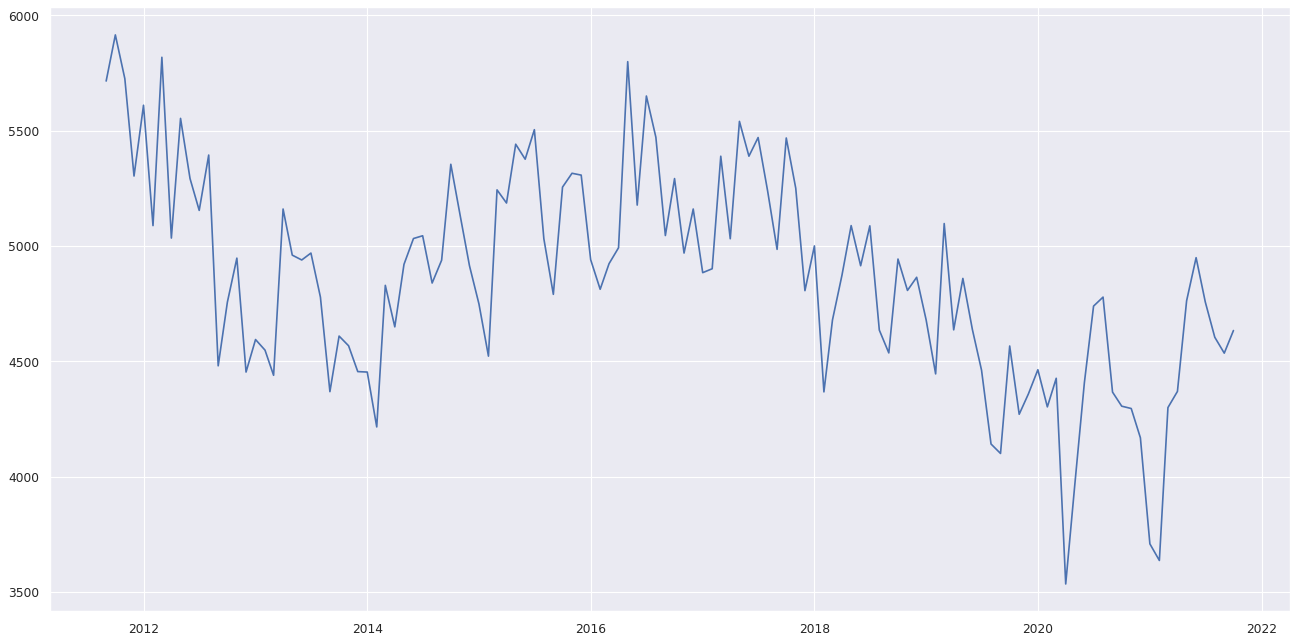

In [116]:
figure(figsize=(20, 10), dpi=80)
plt.plot(df.index, df['y'], )

In [117]:
train = df[df.index < "2017-12-02"]
train = train[train.index > "2011-12-01"]
test = df[df.index > "2017-12-01"]
#test = test[test.index< "2020-01-01"]

In [118]:
train.reset_index(inplace = True)
train.rename(columns={ train.columns[0]: "Month" }, inplace = True)
train.rename(columns={ train.columns[1]: "Predictions" }, inplace = True)
train["Month"] = pd.to_datetime(train["Month"])
train.set_index("Month", inplace = True)
test.reset_index(inplace = True)
test_time = test["ds"]

In [119]:


#!pip install pmdarima
from pmdarima.arima import auto_arima


In [120]:
arima_model =  auto_arima(train,start_p=0, d=0, max_iter = 100, start_q=0, 
                          max_p=5, max_d=3, max_q=3, start_P=0, 
                          D=1, start_Q=0, max_P=3, max_D=3,
                          max_Q=3, m=12, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True, Stepwise = True,
                          random_state=20,n_fits = 50, n_jobs = -1 , scoring  = "mse")




/usr/local/lib/python3.7/dist-packages/pmdarima/arima/_validation.py:77: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  'Falling back to stepwise parameter search.' % n_jobs)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=891.267, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=870.194, Time=0.37 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=889.332, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=885.842, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=863.648, Time=1.08 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=865.062, Time=2.06 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=865.844, Time=1.44 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=864.078, Time=0.65 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=2.79 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=867.730, Time=0.64 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=863.826, Time=1.33 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=864.911, Time=1.34 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=865.275, Time=0.92 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AI

In [121]:
arima_model

ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True)

In [122]:
#Multiple tests gave us the best result in terms of fit and reduces overfit with the order of (2,1,1) for seasonality, even though it has a slightly higher AIC scores

In [123]:
mod_order =(2,1,1)
mod_seasonal =arima_model.seasonal_order
mod_order_suppress_warnings =arima_model.suppress_warnings 
mod_order_intercept =arima_model.with_intercept

In [124]:
#The best parameters (according to auto sarima and further tests) are given to the armamodel

In [125]:
ARMAmodel = SARIMAX(test["y"],order= mod_order , scoring_args={}, seasonal_order= mod_seasonal,
      suppress_warnings= mod_order_suppress_warnings, with_intercept= mod_order_intercept)

In [126]:
last_val =  test["ds"].iloc[-1]
data = []
previous_date = last_val

# Creats the amont of months that should be predicted 

prediction_timeframe = 12
for i in range(prediction_timeframe):
  previous_date = previous_date + relativedelta.relativedelta(months=1)
  data.append(previous_date)





In [127]:
month_pred = pd.DataFrame(data, columns = ['ds'])

In [128]:
month_pred

,ds
0,2021-11-01
1,2021-12-01
2,2022-01-01
3,2022-02-01
4,2022-03-01
5,2022-04-01
6,2022-05-01
7,2022-06-01
8,2022-07-01
9,2022-08-01


In [129]:
month_pred["y"] = 0

In [130]:
month_pred

,ds,y
0,2021-11-01,0
1,2021-12-01,0
2,2022-01-01,0
3,2022-02-01,0
4,2022-03-01,0
5,2022-04-01,0
6,2022-05-01,0
7,2022-06-01,0
8,2022-07-01,0
9,2022-08-01,0


In [131]:
dd = month_pred
test_dates = test.append(dd)

In [132]:
# Datframe to feed into the arima prediction model to predict future crimes (outside of the timeframe of the currently provided data)

In [133]:
test_dates


,ds,y
0,2018-01-01,5000
1,2018-02-01,4367
2,2018-03-01,4679
3,2018-04-01,4873
4,2018-05-01,5088
5,2018-06-01,4914
6,2018-07-01,5087
7,2018-08-01,4635
8,2018-09-01,4536
9,2018-10-01,4943


In [134]:
ARMAmodel = ARMAmodel.fit(outer_iter = 400)
y_pred = ARMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05)
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"]

/usr/local/lib/python3.7/dist-packages/statsmodels/base/optimizer.py:23: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: outer_iter. After release 0.14, this will raise.
  FutureWarning


In [135]:
#Second model for future predictions

In [136]:
y_pred_out

0     4467.045856
1     4374.386336
2     4057.901530
3     3941.248547
4     4571.625034
5     4377.387517
6     4710.763373
7     4770.234521
8     4625.623846
9     4430.112315
10    4342.851690
11    4558.081277
12    4359.861700
13    4327.806195
14    4147.471702
15    4018.840166
16    4473.344698
17    4055.579957
18    4429.966843
19    4633.916483
20    4653.405252
21    4544.256103
22    4343.969639
23    4451.711457
24    4322.665587
25    4251.930884
26    3961.278407
27    3853.652016
28    4396.759968
29    4170.210256
30    4547.657398
31    4733.271498
32    4664.106670
33    4532.100024
34    4387.801505
35    4501.298055
36    4353.314128
37    4278.151333
38    3987.818406
39    3875.210836
40    4441.533016
41    4210.032010
42    4571.667586
43    4714.342134
44    4626.138820
45    4473.680182
Name: Predictions, dtype: float64

In [137]:
# Report the RMSE for our current time period of the test set

In [138]:
import numpy as np
from sklearn.metrics import mean_squared_error

arma_rmse = np.sqrt(mean_squared_error(test["y"].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

RMSE:  418.5917348089814


In [139]:
# Prediction for the period further than the test dataset

In [140]:
ARMAmodel = SARIMAX(test["y"],order= mod_order , scoring_args={}, seasonal_order= mod_seasonal,
      suppress_warnings= mod_order_suppress_warnings, with_intercept= mod_order_intercept)

ARMAmodel = ARMAmodel.fit(outer_iter = 400)
y_pred = ARMAmodel.get_forecast(len(test_dates.index))
y_pred_df = y_pred.conf_int(alpha = 0.05)
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test_dates.index
y_pred_out = y_pred_df["Predictions"]

/usr/local/lib/python3.7/dist-packages/statsmodels/base/optimizer.py:23: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: outer_iter. After release 0.14, this will raise.
  FutureWarning


In [141]:
y_pred_out

0     4467.045856
1     4374.386336
2     4057.901530
3     3941.248547
4     4571.625034
5     4377.387517
6     4710.763373
7     4770.234521
8     4625.623846
9     4430.112315
10    4342.851690
11    4558.081277
12    4359.861700
13    4327.806195
14    4147.471702
15    4018.840166
16    4473.344698
17    4055.579957
18    4429.966843
19    4633.916483
20    4653.405252
21    4544.256103
22    4343.969639
23    4451.711457
24    4322.665587
25    4251.930884
26    3961.278407
27    3853.652016
28    4396.759968
29    4170.210256
30    4547.657398
31    4733.271498
32    4664.106670
33    4532.100024
34    4387.801505
35    4501.298055
36    4353.314128
37    4278.151333
38    3987.818406
39    3875.210836
40    4441.533016
41    4210.032010
42    4571.667586
43    4714.342134
44    4626.138820
45    4473.680182
0     4344.718663
1     4493.617984
2     4329.528726
3     4269.954336
4     4018.405295
5     3900.569897
6     4425.453771
7     4128.655962
8     4496.142795
9     4664

In [142]:
test_dates["y"] = y_pred_out

In [143]:
test_dates.head(40)

,ds,y
0,2018-01-01,4467.045856
1,2018-02-01,4374.386336
2,2018-03-01,4057.901530
3,2018-04-01,3941.248547
4,2018-05-01,4571.625034
5,2018-06-01,4377.387517
6,2018-07-01,4710.763373
7,2018-08-01,4770.234521
8,2018-09-01,4625.623846
9,2018-10-01,4430.112315


In [144]:
test_dates['Month']= pd.to_datetime(test_dates['ds'])


In [145]:
test_dates.drop("ds", axis =1, inplace = True)

In [146]:
test_dates.set_index("Month", inplace = True)

In [147]:

train.reset_index(inplace = True)
train['Month']= pd.to_datetime(train['Month'])
train.set_index("Month",inplace = True)

#test.reset_index(inplace = True)
test['ds']= pd.to_datetime(test['ds'])
test.set_index("ds", inplace = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


''

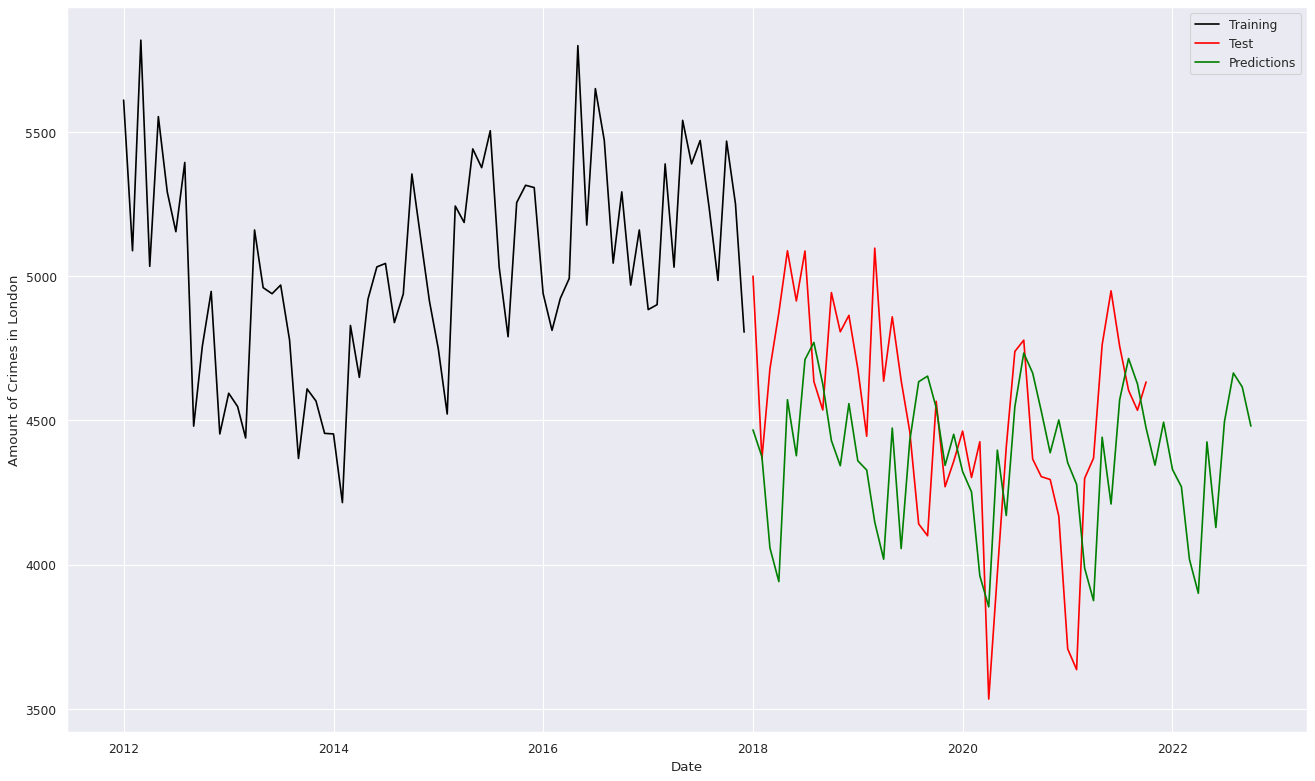

In [148]:

fig = figure(figsize=(20, 12), dpi=80)
plt.plot(train, color = "black", label = 'Training')
plt.plot(test, color = "red", label ='Test')
plt.plot(test_dates, color='green', label = 'Predictions')
plt.legend()
plt.savefig("Prediction.png")
plt.xlabel('Date')
plt.ylabel('Amount of Crimes in London')
;